# Cargo Holds:  Clean or Dirty?
___

### Data Structure

With the images explored and classified they now need to be structed in a way to avoid data leakage and make them available for modeling.  This project is working with an imbalanced and small dataset.  The classes are roughy split 33% in the minority class and 67% in the majority class.  The dataset is also limited to 834 images.  These issues need to be addressed before training the model on the dataset.  

There are several ways to address imbalanced and small datasets.  To address imbalanced datasets the data can be oversampled, undersampled, add synethetic data, and weighting the classes during model training.  For this problem, image classification, we are electing to generate synthetic data.  This reduces some bias that is introduced from oversampling by relying on the same image repeatedly.  Through a mix of flipping, cropping, zooming, rotations, adjusting brightness, etc the generaged images will augment the existing data.  This will also address the small dataset by increasing the size.

Another reason for electing synthetic data is that accumulating new data will be easier which will allow this approach to be discarded when the dataset becomes large enough.  The average vessel generates 200-300 images everytime it changes cargos.  At which point addressing an imbalanced and small dataset will no longer be an issue.  A single vessel can generate 1200 to 3600 images a year.  There are thousands of vessels that undertake hold cleaning between cargoes.

Before augmenting the data, an unaltered set of images from both classes are beting set aside to serve as a test set to evaluate the model's performance.  This set will not be altered as to represent the real world work process.  

After setting aside a test set, the remaining data will be augmented.  The amount augmented will be in excess of the targeted amount as many will be discarded due to unrealistic alterations.  Normally the target size for a dataset with a thousand images per class (without augmentation).  For this problem we are settling at around half that, at 500-600 images in each class.  This amount was considered to add some to the majority class (to avoid the model seeing only altered images in the minority class), to avoid creating a dataset that is predominantly synthetic, and the model will also see more augmented images during training.     

**This workflow is obviously not ideal and limits the confidence in the results.  Under the circumstances of incomplete data collection, this approach is allowing proof of concept to determine if the model is able to learn the distinctions between classes.**

Lastly, a training and validation set will be created from the augmented images.  The training set will be used to train the model.  The validation set will be used to fine tune the hyperparameters.

For this project the dataset will be split roughly 80% training, 10% validation, and 10% test set.

In [1]:
import os
import shutil

import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tensorflow.keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator

In [2]:
images_df = pd.read_csv('../data/data_eda.csv')
images_df.head()

,source,original_name,class
0,Nippon Paint Marine,cargo hold 1.jpg,clean
1,Nippon Paint Marine,cargo hold 2.jpg,clean
2,Nippon Paint Marine,cargo hold 3.jpg,clean
3,Nippon Paint Marine,cargo hold 4.jpg,clean
4,Seachios,038772db-641a-4b17-bda8-52d5304d3fa4.jpg,dirty


In [3]:
# number of images to hold back for test set
test_size = round((images_df[images_df['class'] == 'dirty'].value_counts().sum() / 10), 0)
test_size

55.0

In [4]:
# Holding back 10 percent of images from each class to generate a test set.

clean_path = '../data/classified/clean/'
clean_images = [i for i in os.listdir(clean_path)]

dirty_path = '../data/classified/dirty/'
dirty_images = [i for i in os.listdir(dirty_path)]

# get ten random clean images
random.shuffle(clean_images)
test_clean_list = clean_images[:55]

# make a filepath
test_clean = []
for image in test_clean_list:
    test_clean.append(clean_path+image)

# move to test directory
for clean_image in test_clean:
    shutil.move(clean_image, '../data/test/clean/')

# get ten random dirty images
random.shuffle(dirty_images)
test_dirty_list = dirty_images[:55]

# make a filepath
test_dirty = []
for image in test_dirty_list:
    test_dirty.append(dirty_path+image)

# move to test directory
for dirty_image in test_dirty:
    shutil.move(dirty_image, '../data/test/dirty/')

In [5]:
# generating more images from original dataset
balance_datagen = ImageDataGenerator(
    brightness_range=(0.5, 1.5),
    rotation_range=45,
    width_shift_range=0.3,
    height_shift_range=0.3,
    shear_range=0.3,
    zoom_range=[0.4, 0.6],
    channel_shift_range=100,
    horizontal_flip=True,
    fill_mode='nearest',
)

In [6]:
def create_synthetics(image_list, target, destination_path):
    """Create more images from a given image list and save to destination"""
    # determine how many images to generate per image
    generate_per_image = target / (len(image_list))

    # loop through image list and generate synthetic images
    for image in image_list:
        try:
            x = load_img(image)
            x = img_to_array(x)
            x = x.reshape((1,) + x.shape)
            i = 0
            for batch in balance_datagen.flow(x, batch_size=1, save_to_dir=destination_path, save_prefix='aug', save_format='jpg'):
                i += 1
                if i > generate_per_image:
                    break  
        except FileNotFoundError:
            print(f'{image} was not found as it was moved to the Test dataset. Skipping ...')
            continue

In [8]:
# Creating more clean images
clean_class_images = [clean_path + file for file in clean_images]
clean_augmented = '../data/augmented/clean/'
clean_target = 375
create_synthetics(clean_class_images, clean_target, clean_augmented)

../data/classified/clean/IMG_2228.jpg was not found as it was moved to the Test dataset. Skipping ...
../data/classified/clean/b3b6aadd-b136-4ab6-8e98-503312887908.jpg was not found as it was moved to the Test dataset. Skipping ...
../data/classified/clean/27d568c2-6951-4792-b1a8-d7f302bc7675.jpg was not found as it was moved to the Test dataset. Skipping ...
../data/classified/clean/7fc59086-aa40-432c-974a-661f3c75c4e5.jpg was not found as it was moved to the Test dataset. Skipping ...
../data/classified/clean/f5b4d1d1-8c4c-476e-bda2-efad682c0f59.jpg was not found as it was moved to the Test dataset. Skipping ...
../data/classified/clean/46474608_1983203988393520_7337535301151096832_n.jpg was not found as it was moved to the Test dataset. Skipping ...
../data/classified/clean/987d3c15-2d78-4c9e-be94-06a24bd4f70b.jpg was not found as it was moved to the Test dataset. Skipping ...
../data/classified/clean/8b43d4e9-222a-4cea-bb4a-ecf24f836efb.jpg was not found as it was moved to the Test

In [9]:
# Creating more dirty images so model sees some orientation variation
dirty_class_images = [dirty_path + file for file in dirty_images]
dirty_augmented = '../data/augmented/dirty/'
dirty_target = 200
create_synthetics(dirty_class_images, dirty_target, dirty_augmented)

../data/classified/dirty/46675044_1983208488393070_2248909549803143168_n.jpg was not found as it was moved to the Test dataset. Skipping ...
../data/classified/dirty/IMG_0393.JPEG was not found as it was moved to the Test dataset. Skipping ...
../data/classified/dirty/a9b54fb6-d5c0-4631-91c2-6f679f606fa4.jpg was not found as it was moved to the Test dataset. Skipping ...
../data/classified/dirty/100560110_2995577947156114_6411977601279066112_n.jpg was not found as it was moved to the Test dataset. Skipping ...
../data/classified/dirty/12c943_6e5e6bce798c4a79bdfe21b92be8e822~mv2.jpg was not found as it was moved to the Test dataset. Skipping ...
../data/classified/dirty/46458048_1983208705059715_3649318696481980416_n.jpg was not found as it was moved to the Test dataset. Skipping ...
../data/classified/dirty/12c943_e081ca72bc674f848fa52b4bdae6665a~mv2.jpg was not found as it was moved to the Test dataset. Skipping ...
../data/classified/dirty/46697409_1983212825059303_108355210482968166

In [10]:
# checking size of augmented classes
num_aug_clean = len([i for i in os.listdir('../data/augmented/clean/')])
num_aug_dirty = len([i for i in os.listdir('../data/augmented/dirty/')])
num_aug_clean, num_aug_dirty

(575, 575)

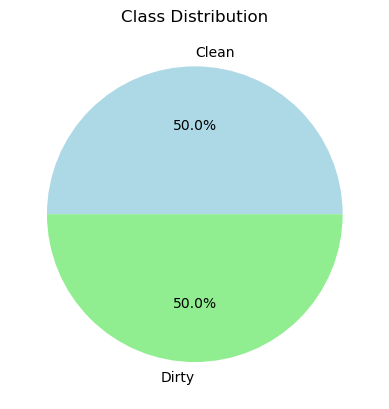

In [11]:
# Pie chart with class distribution
fig, ax = plt.subplots()
ax.pie(x=[num_aug_clean, num_aug_dirty], labels=['Clean', 'Dirty'], colors=['lightblue', 'lightgreen'], autopct='%1.1f%%')
ax.set_title('Class Distribution')
plt.show;

In [12]:
# split the remaining images into training and validation datasets

# training & validation clean
try:
    augmented_clean_path = '../data/augmented/clean/'
    augmented_clean_images = [i for i in os.listdir(augmented_clean_path)]
    random.shuffle(augmented_clean_images)
    
    train_clean = []
    augmented_clean_train = augmented_clean_images[:520]
    for act_image in augmented_clean_train:
        train_clean.append(os.path.join(augmented_clean_path + act_image))
    for train_clean_image in train_clean:
        shutil.move(train_clean_image, '../data/train/clean/')
        
    val_clean = []
    augmented_clean_val = augmented_clean_images[520:]
    for acv_image in augmented_clean_val:
        val_clean.append(os.path.join(augmented_clean_path + acv_image))
    for val_clean_image in val_clean:
        shutil.move(val_clean_image, '../data/validate/clean/')
        
    #training & validation dirty
    augmented_dirty_path = '../data/augmented/dirty/'
    augmented_dirty_images = [i for i in os.listdir(augmented_dirty_path)]
    random.shuffle(augmented_dirty_images)
    
    train_dirty = []
    augmented_dirty_train = augmented_dirty_images[:520]
    for adt_image in augmented_dirty_train:
        train_dirty.append(os.path.join(augmented_dirty_path + adt_image))
    for train_dirty_image in train_dirty:
        shutil.move(train_dirty_image, '../data/train/dirty/')
    
    val_dirty = []
    augmented_dirty_val = augmented_dirty_images[520:]
    for adv_image in augmented_dirty_val:
        val_dirty.append(os.path.join(augmented_dirty_path + adv_image))
    for val_dirty_image in val_dirty:
        shutil.move(val_dirty_image, '../data/validate/dirty/')

except FileNotFoundError as e:
    print(f'Image was not found {e} as it was moved to the Test dataset. Skipping ...')

In [13]:
# check the distribution after the splits
num_train_clean = len([i for i in os.listdir('../data/train/clean/')])
num_train_dirty = len([i for i in os.listdir('../data/train/dirty/')])

num_val_clean = len([i for i in os.listdir('../data/validate/clean/')])
num_val_dirty = len([i for i in os.listdir('../data/validate/dirty/')])

num_test_clean = len([i for i in os.listdir('../data/test/clean/')])
num_test_dirty = len([i for i in os.listdir('../data/test/dirty/')])

num_train_clean, num_train_dirty, num_val_clean, num_val_dirty, num_test_clean, num_test_dirty

(520, 520, 55, 55, 55, 55)

In [26]:
# Add new name, not renaming
images_df['new_name'] = images_df['class'] + '_' + images_df.index.astype(str)
images_df.sort_values(by='source', inplace=True)
images_df.head(5)

,source,original_name,class,new_name
0,Nippon Paint Marine,cargo hold 1.jpg,clean,clean_0
1,Nippon Paint Marine,cargo hold 2.jpg,clean,clean_1
2,Nippon Paint Marine,cargo hold 3.jpg,not_used,not_used_2
3,Nippon Paint Marine,cargo hold 4.jpg,clean,clean_3
175,Seachios,aef49c5d-f68f-4381-9cae-e543f1bb2b83.jpg,clean,clean_175


In [27]:
# Update dataframe to indicate train/validate/test split

# Create lists of where each image was assigned
train_clean_path = '../data/train/clean'
train_clean_images = [i for i in os.listdir(train_clean_path)]
train_dirty_path = '../data/train/dirty'
train_dirty_images = [i for i in os.listdir(train_dirty_path)]
validate_clean_path = '../data/validate/clean'
validate_clean_images = [i for i in os.listdir(validate_clean_path)]
validate_dirty_path = '../data/validate/dirty'
validate_dirty_images = [i for i in os.listdir(validate_dirty_path)]
test_clean_path = '../data/test/clean'
test_clean_images = [i for i in os.listdir(test_clean_path)]
test_dirty_path = '../data/test/dirty'
test_dirty_images = [i for i in os.listdir(test_dirty_path)]


# store them in a dictionary and convert to a dataframe
split_dict = {
    'split': 
    ['train_clean_images'] * len(train_clean_images) + 
    ['train_dirty_images'] * len(train_dirty_images) +
    ['validate_clean_images'] * len(validate_clean_images) + 
    ['validate_dirty_images'] * len(validate_dirty_images) +
    ['test_clean_images'] * len(test_clean_images) + 
    ['test_dirty_images'] * len(test_dirty_images),
    'original_name': 
    train_clean_images + 
    train_dirty_images + 
    validate_clean_images + 
    validate_dirty_images +
    test_clean_images + 
    test_dirty_images
}

split_df = pd.DataFrame(split_dict)
split_df = pd.merge(split_df, images_df, on='original_name', how='left')
split_df['source'] = split_df['source'].fillna('synthetic')
split_df.head()

,split,original_name,source,class,new_name
0,train_clean_images,046c7aff-205a-46c5-8412-6b6fac84fb00.jpg,Seachios,clean,clean_6
1,train_clean_images,0a9ce194-f3f2-4efe-9621-c0df37e23e77.jpg,Seachios,clean,clean_9
2,train_clean_images,0b80c8d6-b7ed-4d79-a706-998916e0a382.jpg,Seachios,clean,clean_11
3,train_clean_images,1000052030.jpg,Seachios,clean,clean_13
4,train_clean_images,1000052031.jpg,Seachios,clean,clean_14


In [28]:
# Saving data split to a csv
split_df.to_csv('../data/data_split.csv', index=False)